## The effect of using different units of diversion and analysis on the variability of your metrics in A/B Testing


### Introduction

Session level metrics are commonly used to measure website performance. Unsurprisingly, when websites begin to run experimentation programs, they often use these same session-level metrics to evaluate A/B experiments. A common experimental setup will therefore split traffic on a cookie and measure the performance of an experiment using a session-level metric (e.g. $\frac{conversions}{session}$)

Once the experiment has run for the pre-determined length of time, a statistical test will be used to compare the performance of some test metric between the control and treatment(s). The statistical tests commonly used to analyse the results of A/B experiments (e.g. $\chi^2 \text{ test, } Z \text{-test, }t \text{-test, } etc.$) make many assumptions, and the robustness of any conclusions derived from these tests depends on the extent to which these assumptions are satisfied. The most stringent assumption is that each observation is independent. 

**In the experimental setup described above, is each session independent? Not necessarily.**

***

#### Violation of the Independence Assumption

When a cookie is used to divert traffic, a user with multiple sessions will be allocated to a single test bucket. **These sessions are unlikely to be independent since user behaviour across sessions is likely to be correlated.** Diverting these users results in groups of correlated sessions appearing in each test bucket. This can significantly increase the variability of your metrics, resulting in your true empirical variability far exceeding your analytical variability. 

Intuitively we can understand this; calculating the session-level conversion from a sample of 5,000 independent sessions will yield a more reliable estimate of the true session-level conversion than that obtained from a sample of 5,000 sessions from 50 users. The variability of our metric should reflect this.


#### Why is this a problem? 

Typically in computing significance tests or confidence intervals, the analytical estimate of the variability will be used. If this is smaller than the true empirical variability, your statistical tests can be unreliable. 

#### Simulation

One way to understand the effect of using different units of diversion and observation is through simulation. In this case, we will simulate an experiment where $\frac{conversions}{session}$ is our test metric and traffic is diverted to either group using a cookie. We'll use the bootstrap technique to construct a sampling distribution and compare this to the expected sampling distribution when we use the analytical variability.

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [4]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Generate session-level data

Each user may have multiple sessions; the number for each user is a Poisson random variable. Similarly, conversion for each session is a Bernoulli random variable.

In [5]:
def create_session_data(n, mu, p):
    "Randomly generate session-level data"
    user_id = pd.util.testing.rands_array(20, n) # random key for each user
    sessions = []
    conversions = []
    
    for e in user_id:
        num_sessions = stats.poisson.rvs(mu)
        user_sessions = np.repeat(e, num_sessions)
        user_conversions = stats.bernoulli.rvs(p, size=num_sessions)
        
        sessions = np.append(sessions, user_sessions)
        conversions = np.append(conversions, user_conversions)

    # return a DataFrame
    data = np.stack([sessions, conversions], axis=1)
    df = pd.DataFrame(data, columns=['userid', 'conversion'], index=None)
    df['conversion'] = pd.to_numeric(df['conversion'])
    df['session'] = df.groupby('userid').cumcount() + 1 # start from 1
    return df

Using the function above, I create our session-level data, specifying three groups of users with distinct sample sizes, conversion rates and sessions per user.

In [6]:
N = [37500, 45000, 300]
mus = [1.5, 1.2, 50]
p_values = [0.2, 0.25, 0.7]
group = ['A', 'B', 'C']

sessions = []
for n, mu, p, g in zip(N, mus, p_values, group):
    data = create_session_data(n, mu, p)
    data['group'] = g
    sessions.append(data)
    
df_sessions = pd.concat(sessions)

Let's have a glance at our data

In [7]:
print ("Number of sessions {}\n".format(len(df_sessions)))
print (df_sessions.head())

Number of sessions 125203

                 userid  conversion  session group
0  J7SriOGXzMirh0sJYCDd         0.0        1     A
1  olTXic6LZvSDTyiXPMBG         0.0        1     A
2  olTXic6LZvSDTyiXPMBG         0.0        2     A
3  P3ERLvlH5SOHSrM2RolK         0.0        1     A
4  P3ERLvlH5SOHSrM2RolK         0.0        2     A


Convert the session-level data to user-level data

In [8]:
def return_user_level_data(session_data):
    user_data = session_data.groupby('userid')['conversion'].agg(['count', 'sum'])
    user_data.columns = ['sessions', 'conversions']
    return user_data

In [9]:
df_users = return_user_level_data(df_sessions)

In [10]:
print ("Number of users {}\n".format(len(df_users)))
print (df_users.head())

Number of users 60892

                      sessions  conversions
userid                                     
000BZKzFq39NeSCfnfBl         2          0.0
0015T8nYcvkHHfKhJRde         1          0.0
007Rzyz15SC6FtteXEvJ         2          0.0
00BoT0nlDOgNweSbzHHU         1          1.0
00BrW25vvpP0tSE916RZ         3          2.0


Print out the session and user-level conversion

In [256]:
user_conversion = df_users.conversions.sum() / df_users.sessions.sum()

print ("Session level conversion: {:.2f} %".format(100 * df_sessions.conversion.mean()))
print ("User level conversion: {:.2f} %".format(100 * user_conversion))

Session level conversion: 28.12 %
User level conversion: 28.12 %


### Simulate an Experiment

Now we want to simulate an experiment whereby we randomly sample users or sessions, construct the sampling distribution and compare the standard error of this distribution to the theoretical number we would expect. We can do this in two ways:
- **By randomly selecting sessions**: under this scheme, each session is treated as if independent.
- **By randomly selecting users**: this mimics the experimental setup described in the introduction; selecting users (using a cookie) but using session-level metrics.

In [257]:
n_simulations = 5000
sample_size = 20000

# use the bootstrap technique to simulate sampling distribution
boot_session = []
for _ in range(n_simulations):
    sample = df_sessions.sample(n=sample_size, replace=True)
    sample_mean = sample.conversion.mean()
    boot_session.append(sample_mean)

# repeat the same for users
boot_user = []
for _ in range(n_simulations):
    sample = df_users.sample(n=sample_size, replace=True)
    sample_mean = sample.conversions.sum() /sample.sessions.sum()
    boot_user.append(sample_mean)

Define some helper functions

In [297]:
def get_theoretical_data(session_data, sample_size):
    mean = np.mean(session_data.conversion)
    se = np.sqrt(mean * (1-mean)/sample_size)
    x = np.linspace(mean - 3*se, mean + 3*se, 100)
    y = stats.norm.pdf(x, mean, se)
    return (x,y)

def calculate_theoretical_ci (session_data, sample_size):
    mean = session_data.conversion.mean()
    se = np.sqrt(mean * (1-mean)/sample_size)
    z = 1.96
    return (mean - z*se, mean + z*se)

def calculate_unlikely_result (boot_data, ci_theoretical):
    lower = ci_theoretical[0]
    upper = ci_theoretical[1]
    significant = [e for e in boot_data if e <= lower or e >= upper]
    return len(significant) / len(boot_data)

def plot_sampling_dist(boot_session, boot_user, session_data, sample_size):
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    sns.distplot(boot_session, hist=True, bins=50, label='Session Randomisation', hist_kws={"alpha":0.5});
    sns.distplot(boot_user, hist=True, bins=50, label='User Randomisation', hist_kws={"alpha":0.5});
    
    # get theoretical distribution
    # use average conversion from session level data
    x,y = get_theoretical_data(session_data, sample_size)
    plt.plot(x, y, linestyle='--', color='black', label='Theoretical Variance')
    plt.legend(loc='best');

    # labels
    plt.ylabel('Frequency')
    plt.xlabel('Session-level Conversion')
    
    plt.grid(True, alpha=0.3);

Plotted below are three sampling distribution:
- The theoretical sampling distribution.
- The sampling distribution when randomising on sessions.
- The sampling distribution when randomising on users.

The theoretical and session-randomised distributions follow each other very closely - this makes sense because the independence asssumption is satisfied. The user-randomised distribution, on the other hand, is far wider than the theoretical distribution.

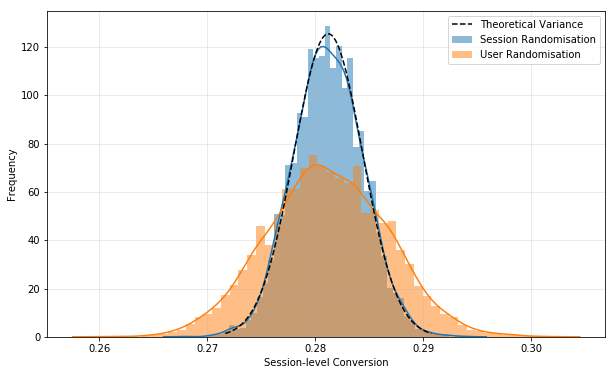

In [298]:
plot_sampling_dist(boot_session, boot_user, df_sessions, sample_size);

We can quantify the effect that this added width of the sampling distribution has on the results of statistical calculations. In theory, we would expect an unlikely result ($\>1.96 * \sigma$ from the mean) to occur 5% of the time. The calculation below shows that is indeed the case when we randomise on session. It is not however true when we randomise on users; in this case, a false positive is 5 times as common as what we would expect.

In [281]:
ci_theoretical = calculate_theoretical_ci(df_sessions, sample_size)
print ('Percentage of Statistically Significant Results with Session Randomisation: {:.2f}%'.
   format(100 * calculate_unlikely_result(boot_session, ci_theoretical)))
print ('Percentage of Statistically Significant Results with User Randomisation: {:.2f}%'.
   format(100 * calculate_unlikely_result(boot_user, ci_theoretical))) 

Percentage of Statistically Significant Results with Session Randomisation: 4.96%
Percentage of Statistically Significant Results with User Randomisation: 26.14%


#### Conclusion & Acknowledgements

Splitting traffic on a cookie but analysing data using session-level metrics can lead to unreliable statistical results. Because the unit of diversion is not the same as the unit of analysis, the variability of your metrics will be higher than the calculated theoretical variability. If uncorrected, this can result in more false positives

In this post, I demonstrated this using simulation. Running A/A experiments is another way of observing the difference between your true empirical variability and your theoretical variability.

I appreciate that this topic has been covered elsewhere I'm under no illusion that this idea is original. Some of the resources I found most useful include:
- [The second Ghost of Experimentation: The fallacy of session based metrics](https://towardsdatascience.com/the-second-ghost-of-experimentation-the-fallacy-of-session-based-metrics-fb65006d30ff) by Skyscanner Engineering
    - The bottom of the article details some solutions to overcome this problem.
- Udacity A/B Testing Course